4


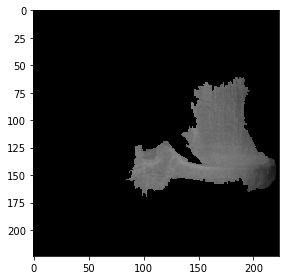

In [1]:
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import numpy as np
import skimage
from skimage import io
from skimage import transform

# Read Image
#model = keras.models.load_model('C:/Users/anton/Desktop/Osteoarthritis Kaggle/Best_resnet152V23.h5')
model = keras.models.load_model('C:/Users/anton/Desktop/Osteoarthritis Kaggle/Best_dense4.h5')
#model = keras.models.load_model('C:/Users/anton/Desktop/Osteoarthritis Kaggle/Best_inceptionv35.h5')
#model = keras.models.load_model('C:/Users/anton/Desktop/Osteoarthritis Kaggle/Best_xception69712.h5')

img = skimage.io.imread("kl4.png")
img = skimage.transform.resize(img, (224,224,3))
#img = (img - 0.5)*2 #Xception pre-processing
#skimage.io.imshow(img)
img2 = img
#print(img.shape)

#Predict class of the image
np.random.seed(222)
img = img*255
preds = model.predict(img[np.newaxis,:,:,:])
#decode_predictions(preds)[0]
#print(preds)
top_pred_classes = preds[0].argsort()[-1:][::-1]
#print(top_pred_classes) #Predicted Class

#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(img, kernel_size=5, max_dist=200, ratio=0.01)
num_superpixels = np.unique(superpixels).shape[0]
#skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))

#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
#print(predictions.shape)

#Compute distances to original image
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
#print(distances.shape)
#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
#print(weights.shape)

#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0] 
print(class_to_explain)
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 3
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image((img/1.5+0.5)*(1./255),mask,superpixels))